In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [93]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [94]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [95]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [96]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [97]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521009,-0.123097


In [98]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [99]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.385649,4.834443


In [100]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [101]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [102]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# **Очистка** 

In [104]:
# Выделим из всего датасета "data" наименования отелей, где есть пропуски координат.
data[data['lat'].isnull()]['hotel_name'].value_counts()

Fleming s Selection Hotel Wien City                 658
Hotel City Central                                  563
Hotel Atlanta                                       389
Maison Albar Hotel Paris Op ra Diamond              290
Hotel Daniel Vienna                                 245
Hotel Pension Baron am Schottentor                  223
Austria Trend Hotel Schloss Wilhelminenberg Wien    194
Derag Livinghotel Kaiser Franz Joseph Vienna        147
NH Collection Barcelona Podium                      146
City Hotel Deutschmeister                            93
Hotel Park Villa                                     61
Cordial Theaterhotel Wien                            57
Holiday Inn Paris Montmartre                         55
Roomz Vienna                                         49
Mercure Paris Gare Montparnasse                      37
Renaissance Barcelona Hotel                          33
Hotel Advance                                        28
Name: hotel_name, dtype: int64

In [105]:
# Составим словарь наименований отеля и их координат
coord_dict = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

In [106]:
# Заполним пропуски в датасете
def fill_coords(row):
    if pd.isna(row.lat):
        coord = coord_dict[row.hotel_name]
        if coord is not None:
            row.lat = coord[0]
            row.lng = coord[1]
            return row
    else:
        return row

data = data.apply(lambda row: fill_coords(row), axis=1)

In [107]:
# Проверим результаты преобразований
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# **Преобразование признаков, создание новых**

In [108]:
# Преобразование признака - Количество дней с отзыва
data['days_since_review']=data['days_since_review'].apply(lambda x: int(x.replace(' days', '').replace(' day', '')))

# Создаем новые признаки из даты отзыва

data['year']=pd.to_datetime(data['review_date']).dt.year
data['month']=pd.to_datetime(data['review_date']).dt.month
data['day']=pd.to_datetime(data['review_date']).dt.day
data['season']=data['month'].apply(lambda x: 
                                                   'winter' if x in [12,1,2] else 
                                                   ('spring' if x in [3,4,5] else 
                                                    ('summer' if x in [6,7,8] else 
                                                     'fall' )))

# Создаем новую колонку 'day_of_week_name' с названием дня недели
data['day_of_week_name'] = pd.to_datetime(data['review_date']).dt.day_name()


# Создаем новую колонку 'day_of_week_name' с номером квартала
data['quarter'] = pd.to_datetime(data['review_date']).dt.quarter


data=pd.get_dummies(data, columns=['season','day_of_week_name', 'quarter'])



In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

**Вывод** - был преобразован в числовой признак days_since_review и созданы новые признаки year, month, days, и семейство season

# **Визуализации, распределения, корреляции**

array([[<AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'review_total_negative_word_counts'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>,
        <AxesSubplot:title={'center':'days_since_review'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lng'}>,
        <AxesSubplot:title={'center':'sample'}>],
       [<AxesSubplot:title={'center':'reviewer_score'}>,
        <AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'season_fall'}>],
       [<AxesSubplot:title={'center':'season_spring'}>,
        <AxesSubplot:title={'center':'season_summer'}>,
  

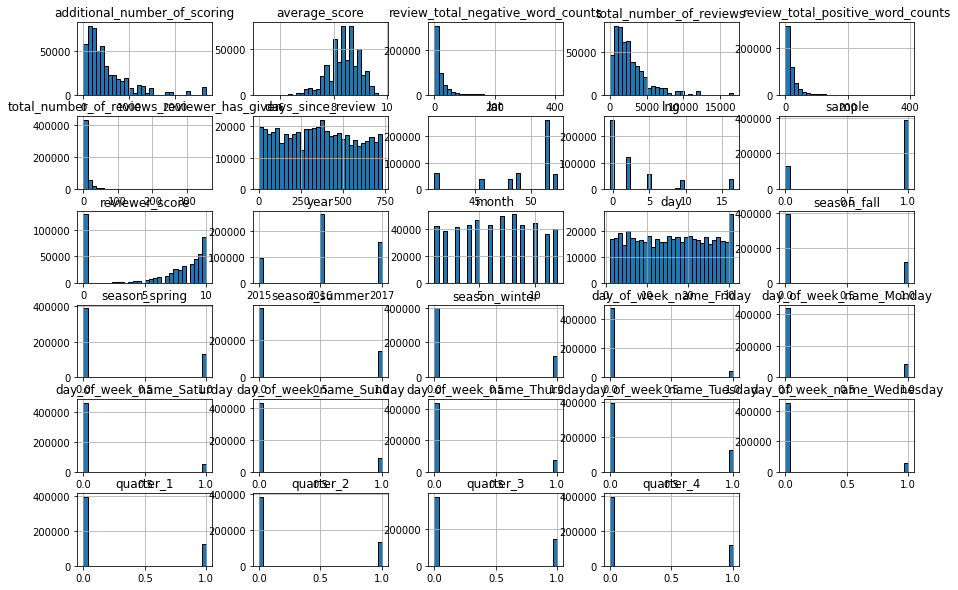

In [110]:

# Одна строка для построения всех гистограмм числовых столбцов
data.hist(figsize=(15, 10), bins=30, edgecolor='black')


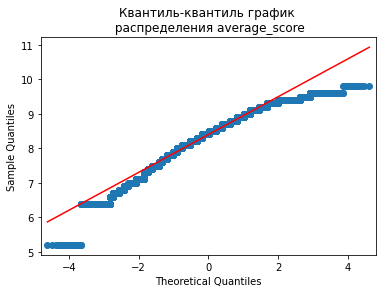

In [111]:

import statsmodels.api as sm
from sklearn import datasets
from matplotlib import pyplot as plt

# загружаем данные


# задаём параметры квантиль-квантиль графика
sm.qqplot(data['average_score'], line='s')
plt.title('Квантиль-квантиль график \n распределения average_score')

# отображаем квантиль-квантиль график
plt.show()


**Вывод** - целевая переменная reviewer_score не распределена ни нормально, ни логонормально. Распределение, похожее на нормальное, есть только у average_score, но судя по Квантиль-квантиль графику таковым не является.<br>
  
Диаграммы рассеяния позволяют сделать вывод о возможной кореляции  с reviewer_score признаков total_number_of_reviews_reviewer_has_given и review_total_positive_word_counts<br><br>


# **Создание новых признаков** 

In [112]:

# Разбираем Tags

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
data['tags'].sample(10)
data['hotel_address'].sample(10)

# Новый признак - Количество тегов в отзыве

data['tags'] = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))

data['num_tags']=data['tags'].apply(lambda x: len(x))


# Функция, которая возвращает тег с заданным ключевым словом
def tags(string_tags):
    for i in string_tags:
        if goal_tag in i:
            return i
    return None

# Функция, которая возвращает 1-0
def tags_1_0(string_tags):
    for i in string_tags:
        if goal_tag in i:
            return 1
    return 0

# Функция, которая возвращает тег с одиним из ключевых слов, обохзначающих кол-во гостей
def num_guests(string_tags):
    for i in string_tags:
        if 'Group' in i or 'Couple' in i or 'Solo' in i or 'young children' in i or 'older children' in i:
            return i
    return None
    
# Новый признак - Тип путешествия
goal_tag='trip'
data['sort_trip']=data['tags'].apply(tags)
my_mode=data['sort_trip'].mode()[0]
data['sort_trip']=data['sort_trip'].fillna(my_mode)
data['sort_trip']=data['sort_trip'].apply(lambda x: 1 if x=='Leisure trip' else 0)


# Новый признак - Количество ночей
goal_tag='night'
data['nights']=data['tags'].apply(tags)
data['nights']=data['nights'].str.replace(r'[^0-9]', '', regex=True)
data['nights']=pd.to_numeric(data['nights'], errors='coerce')
my_median=data['nights'].median()
data['nights']=data['nights'].fillna(my_median)


# Новый признак - Отправка отзыва с телефона
goal_tag='Submitted from a mobile device'
data['mobile_review']=data['tags'].apply(tags_1_0)


# Количество гостей
data['num_guests']=data['tags'].apply(num_guests)


# Проверка
display(data['sort_trip'].value_counts())
display(data['nights'].value_counts())
display(data['mobile_review'].value_counts())
display(data['num_guests'].value_counts())


data = pd.get_dummies(data, columns=['num_guests'])

1    432799
0     82939
Name: sort_trip, dtype: int64

1.0     193639
2.0     134142
3.0      95821
4.0      47816
5.0      20842
6.0       9775
7.0       7398
8.0       2502
9.0       1292
10.0       889
11.0       418
12.0       316
14.0       247
13.0       246
15.0       117
16.0        57
17.0        42
18.0        33
19.0        29
21.0        23
20.0        19
27.0        11
30.0        11
23.0        10
22.0        10
25.0         7
26.0         7
28.0         7
24.0         6
29.0         5
31.0         1
Name: nights, dtype: int64

1    307640
0    208098
Name: mobile_review, dtype: int64

Couple                        252294
Solo traveler                 108545
Group                          65392
Family with young children     61015
Family with older children     26349
Name: num_guests, dtype: int64

In [ ]:
# Разбираем negative_review и positive_review

from sklearn.feature_extraction.text import TfidfVectorizer

# Создаем TF-IDF векторизатор
# min_df: игнорировать слова, которые встречаются реже, чем в указанном проценте/количестве документов
# max_features: ограничить количество признаков (слов)
tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words=None, ngram_range=(1,2)) # ngram_range для биграмм

data['combined_review'] = data['positive_review'] + " " + data['negative_review']

# Обучаем векторизатор и трансформируем комментарии
tfidf_features = tfidf_vectorizer.fit_transform(data['combined_review'])

# Преобразуем в DataFrame (опционально, для удобства просмотра)
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names())
tfidf_df.index = data.index # Сохраняем индексы

print("Размерность TF-IDF признаков для объединенного текста:", tfidf_features.shape)
print("Пример TF-IDF признаков (первые 5 слов):")
print(tfidf_df.iloc[:, :5]) # Выводим первые 5 колонок с признаками
# Вы можете объединить tfidf_df с вашим основным df, но обычно это слишком много колонок
print("-" * 50)

Размерность TF-IDF признаков для объединенного текста: (515738, 100)
Пример TF-IDF признаков (первые 5 слов):


In [ ]:
# Разбираем negative_review и positive_review

# Переинициализация, если вы запускаете этот блок отдельно
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data['combined_review'])]
model = Doc2Vec(vector_size=50, min_count=1, epochs=20, dm=1)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Получаем векторы для каждого документа в DataFrame
doc2vec_features = np.array([model.dv[str(i)] for i in range(len(df))])

# Преобразуем в DataFrame для удобства
doc2vec_df = pd.DataFrame(doc2vec_features, index=df.index)
# Можно дать более осмысленные имена колонкам, например 'doc2vec_0', 'doc2vec_1' и т.д.
doc2vec_df.columns = [f'doc2vec_{i}' for i in range(doc2vec_df.shape[1])]

print("Пример Doc2Vec признаков (первые 5 размерностей):")
print(doc2vec_df.iloc[:, :5]) # Выводим первые 5 колонок с признаками
# doc2vec_df можно объединить с вашим основным df:
# df_final = pd.concat([data, doc2vec_df], axis=1)
print("-" * 50)

In [70]:
# Разбираем negative_review и positive_review


data['positive_char_count']=data['positive_review'].str.len()
data['negative_char_count']=data['negative_review'].str.len()

display(data['positive_char_count'].head())
display(data['negative_char_count'].head())


import nltk
nltk.download('vader_lexicon') # Раскомментируйте, если VADER не установлен

from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

data['pos_sentiment']=data['positive_review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
data['neg_sentiment']=data['negative_review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

display(data['pos_sentiment'].head())
display(data['neg_sentiment'].head())

# подсчитывает количество заглавных букв в тексте (на случай если кто-то злой капслоком писал)
def count_uppercase_letters(text):
   
    if not isinstance(text, str):
        return 0 # Возвращаем 0, если входное значение не является строкой (например, NaN)
    count = 0
    for char in text:
        if char.isupper(): # Проверяем, является ли символ заглавной буквой
            count += 1
            
    return round(count/len(text),4)
    
data['neg_big_chairs_per']=data['negative_review'].apply(count_uppercase_letters)
data['pos_big_chairs_per']=data['positive_review'].apply(count_uppercase_letters)
display(data['neg_big_chairs_per'].head())
display(data['pos_big_chairs_per'].head())

0    337
1     11
2     27
3    155
4     32
Name: positive_char_count, dtype: int64

0    262
1     44
2      9
3     11
4     11
Name: negative_char_count, dtype: int64

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


0    0.9615
1    0.3400
2    0.6908
3    0.9153
4    0.7717
Name: pos_sentiment, dtype: float64

0   -0.0554
1   -0.2960
2    0.0000
3   -0.7096
4   -0.7096
Name: neg_sentiment, dtype: float64

0    0.0115
1    0.0227
2    0.1111
3    0.1818
4    0.1818
Name: neg_big_chairs_per, dtype: float64

0    0.0089
1    0.1818
2    0.0370
3    0.0258
4    0.0312
Name: pos_big_chairs_per, dtype: float64

In [71]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

None

In [72]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
data['hotel_address'].sample(10)

50408                38 Rue Du Faubourg Saint Honore 8th arr 75008 Paris France
354550           Ferdinand Bolstraat 333 Oud Zuid 1072 LH Amsterdam Netherlands
68899          284 To 302 Waterloo Road Southwark London SE1 8RQ United Kingdom
36256                        51 57 rue de Courcelles 8th arr 75008 Paris France
345889    Via Lucio Giunio Columella 36 Distretto Viale Monza 20128 Milan Italy
422735                        2 The Avenue Ealing London W13 8PH United Kingdom
322386     34 37 Bedford Place Bloomsbury Camden London WC1B 5JR United Kingdom
58837        Half Moon Street Westminster Borough London W1J 7BH United Kingdom
13969                          Sonnwendgasse 8 10 Favoriten 1100 Vienna Austria
395153                         Euston Road Camden London NW1 2AR United Kingdom
Name: hotel_address, dtype: object

In [73]:

# Создаем новые признаки на основе reviewer_nationality

# Обрезаем мусорные пробелы в начале и конце
data['reviewer_nationality']= data['reviewer_nationality'].str.strip()
value_country=data['reviewer_nationality'].value_counts(normalize=True)

# Создадим еще одну категорию - совпадаение страны отеля и гостя
country_list=value_country.index

def get_country_from_adress(adress):

    for i in country_list:
        if i in adress:
            return i
    return 'Other'


data['hotel_country']=data['hotel_address'].apply(get_country_from_adress)
data['hotel_reviewer_country_equal']=(data['hotel_country']==data['reviewer_nationality'])
data['hotel_reviewer_country_equal']=data['hotel_reviewer_country_equal'].apply(lambda x: 1 if x==True else 0)
display(data['hotel_reviewer_country_equal'].value_counts())

# Создаем новые катерогии через One Hot кодироваие
data = pd.get_dummies(data, columns=['hotel_country'])

# через двоичное кодирование
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
data = bin_encoder.fit_transform(data)



0    337335
1    178403
Name: hotel_reviewer_country_equal, dtype: int64

In [74]:
# Создаем новые признаки на основе hotel_address
data['hotel_address'].sample(20)

def extract_city(hotel_address):
    if 'London' not in hotel_address:
        parts = hotel_address.split(' ')
        # Предполагаем, что город - последний элемент перед страной
        city = parts[-2].strip()  
        return city
    return 'London'

# Применяем функцию к каждому адресу
data['city'] = data['hotel_address'].apply(extract_city)

data['city'].value_counts()

data=pd.get_dummies(data, columns=['city'])

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 71 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality_0                      515738 non-null  int64  
 6   reviewer_nationality_1                      515738 non-null  int64  
 7   reviewer_nationality_2                      515738 non-null  int64  
 8   reviewer_nationality_3                      515738 non-null  int64  
 9   reviewer_nationality_4                      515738 non-null  int64  
 

**Вывод** - создали несколько новых числовых признаков из текстовых признаков - negative_review, positive_review, tags,  hotel_address 

# **Мультиколлинераность**

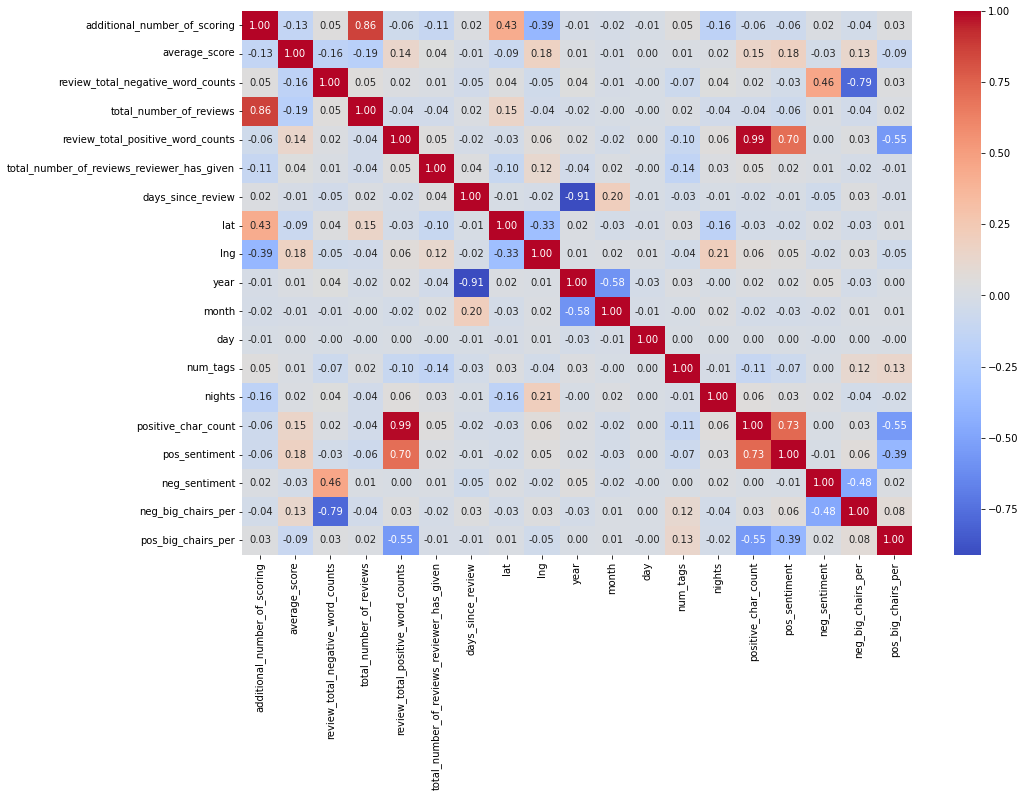

In [76]:

# Числовые признаки
num_cols =[
    'additional_number_of_scoring',
    'average_score',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given',
    'days_since_review',
    'lat',
    'lng',
    'year',
    'month',
    'day',
    'num_tags',
    'nights',
    'positive_char_count',
    'pos_sentiment',
    'neg_sentiment',
    'neg_big_chairs_per',
    'pos_big_chairs_per'
]

plt.rcParams['figure.figsize'] = (15,10)

# # так как признаки не нормально распределены, то метод Пирсона отпадает. 
sns.heatmap( data[num_cols].corr(method='spearman'), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


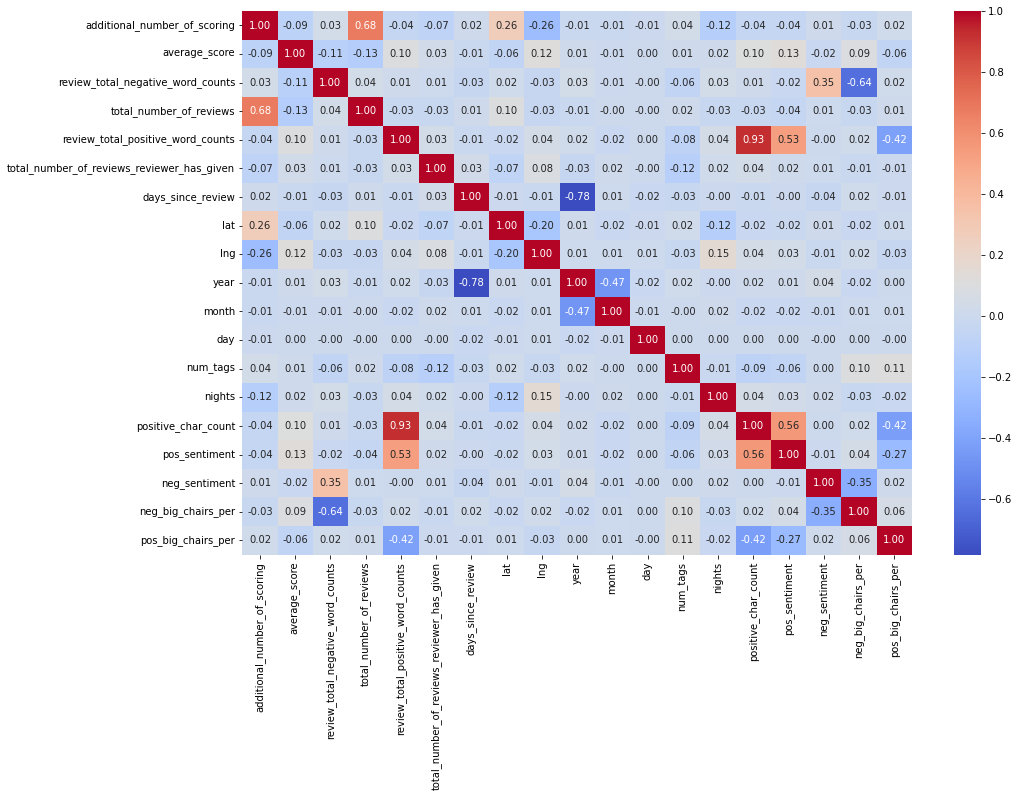

In [77]:
plt.rcParams['figure.figsize'] = (15,10)

sns.heatmap( data[num_cols].corr(method='kendall'), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

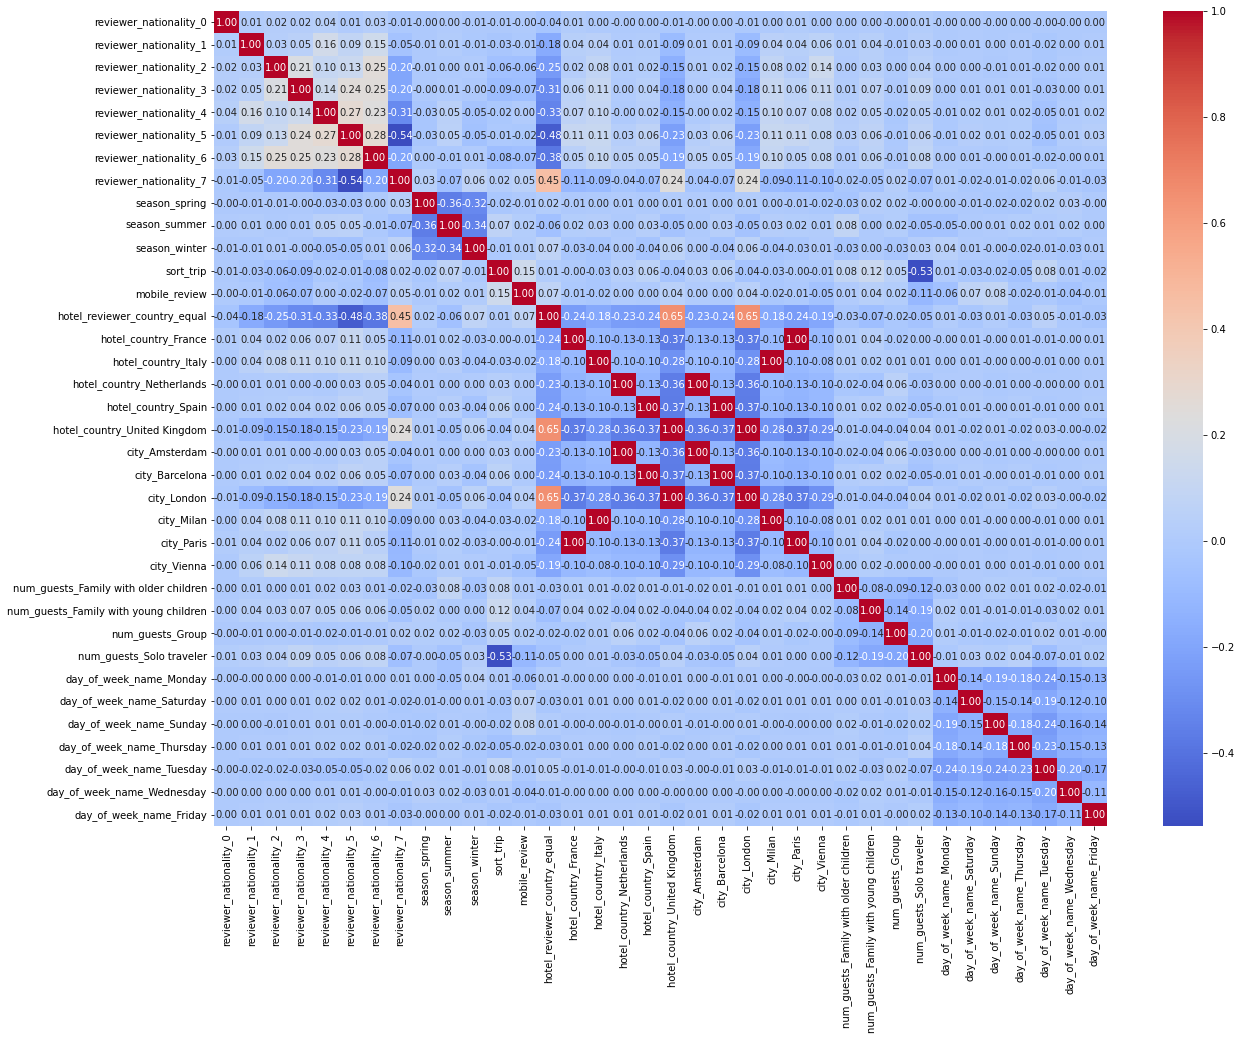

In [78]:


# Категориальные признаки
cat_cols=[
    'reviewer_nationality_0',
    'reviewer_nationality_1',
    'reviewer_nationality_2',
    'reviewer_nationality_3',
    'reviewer_nationality_4',
    'reviewer_nationality_5',
    'reviewer_nationality_6',
    'reviewer_nationality_7',
    'season_spring',
    'season_summer',
    'season_winter',
    'sort_trip',
    'mobile_review',
    'hotel_reviewer_country_equal',
    'hotel_country_France',
    'hotel_country_Italy',
    'hotel_country_Netherlands',
    'hotel_country_Spain',
    'hotel_country_United Kingdom',
    'city_Amsterdam',
    'city_Barcelona',
    'city_London',
    'city_Milan',
    'city_Paris',
    'city_Vienna',
    'num_guests_Family with older children',
    'num_guests_Family with young children',
    'num_guests_Group',
    'num_guests_Solo traveler',
    'day_of_week_name_Monday',
    'day_of_week_name_Saturday',
    'day_of_week_name_Sunday',
    'day_of_week_name_Thursday',
    'day_of_week_name_Tuesday',
    'day_of_week_name_Wednesday',
    'day_of_week_name_Friday',
  ]

plt.rcParams['figure.figsize'] = (20,15)


sns.heatmap( data[cat_cols].corr(method='kendall'), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


In [79]:
# Удаляем все признаки с кореляцией 1

# List of columns to drop
columns_to_drop = [
    'hotel_country_France',
    'hotel_country_Italy',
    'hotel_country_Netherlands',
    'hotel_country_Spain',
    'hotel_country_United Kingdom',
]

data.drop(columns=columns_to_drop, axis=1, inplace=True)

In [80]:
num_cols =list(set(num_cols)-set(columns_to_drop))
cat_cols =list(set(cat_cols)-set(columns_to_drop))

**Вывод** - тепловые карты показывают мультиколлинеарность некоторых признаков. Но при удалении ухудшался MAE. Оставил все, кроме корреляции = 1.

# **Проверка значимости признаков и отбор**

<AxesSubplot:>

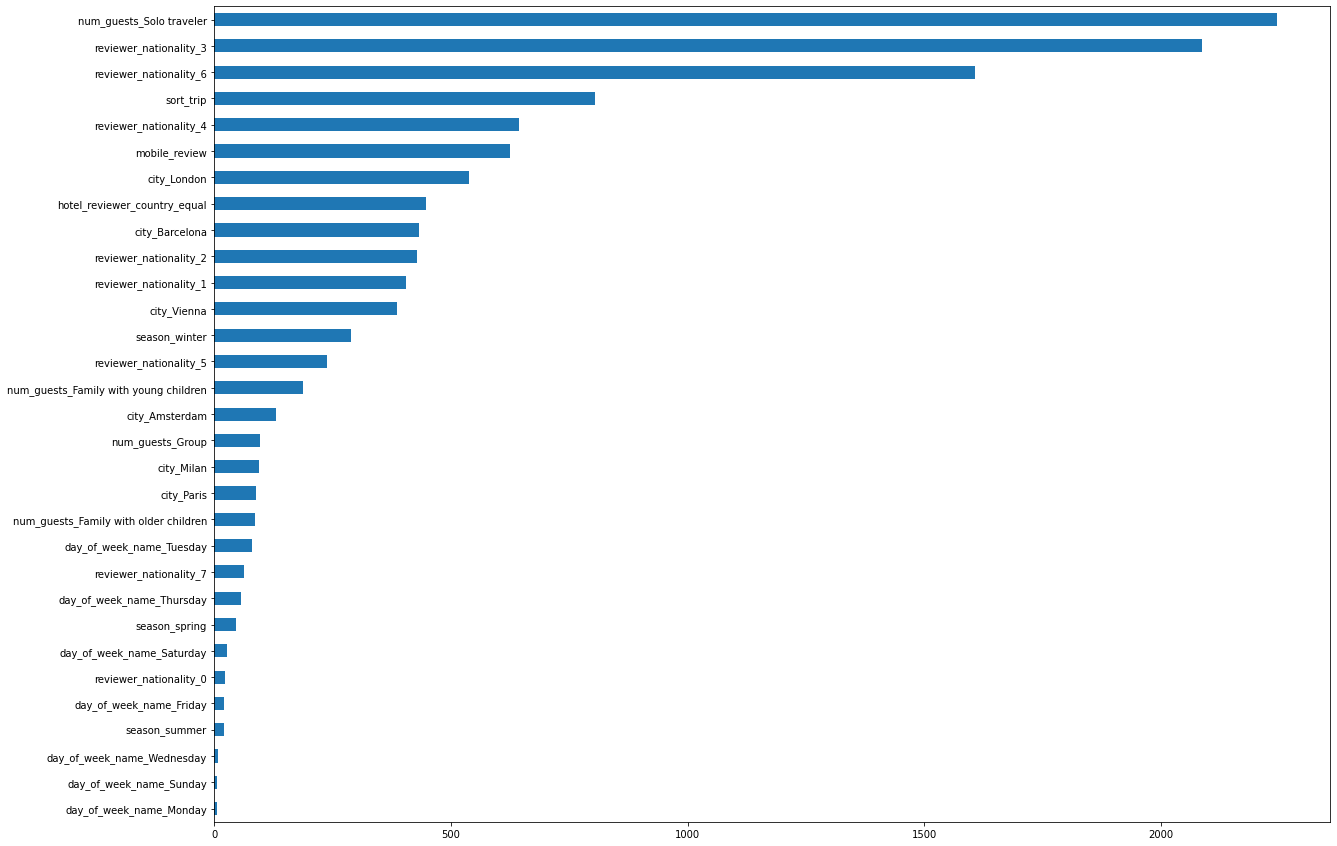

In [81]:

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(data[cat_cols], data['reviewer_score'].astype('int'))[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

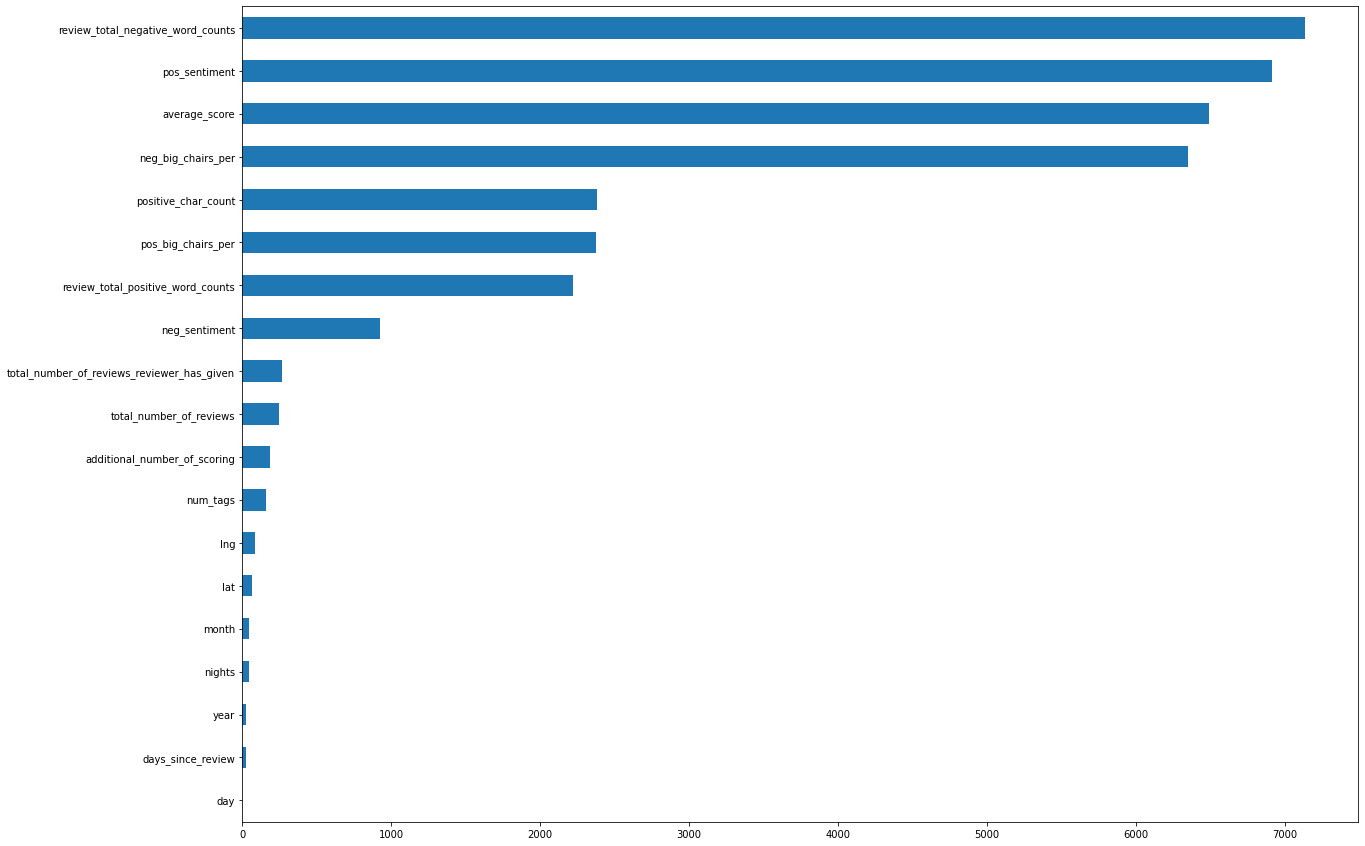

In [82]:
# Значимость для непрерывных признаков — тест ANOVA

from sklearn.feature_selection import f_classif # anova


imp_num = pd.Series(f_classif(data[num_cols], data['reviewer_score'].astype('int'))[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')


In [83]:
data.drop(columns=['day'], axis=1, inplace=True)

**Вывод** - мы видим более и менее значимые признаки. Но так как общее количество признаков невелико, то решил удалить только day

# **Реализация модели обучения**

In [84]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
object_columns = data.select_dtypes(include='object').columns
data.drop(columns=object_columns, inplace=True)

In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality_0                      515738 non-null  int64  
 3   reviewer_nationality_1                      515738 non-null  int64  
 4   reviewer_nationality_2                      515738 non-null  int64  
 5   reviewer_nationality_3                      515738 non-null  int64  
 6   reviewer_nationality_4                      515738 non-null  int64  
 7   reviewer_nationality_5                      515738 non-null  int64  
 8   reviewer_nationality_6                      515738 non-null  int64  
 9   reviewer_nationality_7                      515738 non-null  int64  
 

In [86]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [87]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [88]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 58), (386803, 58), (386803, 57), (309442, 57), (77361, 57))

In [89]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [90]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


In [101]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error (y_test, y_pred))

MAE: 0.8619162368635354
MAPE: 12.26785033862259


In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

**Вывод** - оценка важности признаков по разным методикам не совпадает

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:

predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

# **Общий вывод по проекту**
<br>
Работа в рамках проекта позволила улучшить метрику проекта MAPE.<br><br>
Были проведены следующие манипуляции:<br>
1. Удаление строковых значений<br>
2. Очистка от пропущенных значений<br>
3. Создание новых признаков<br>
4. Преобразование признаков<br>
5. Отбор признаков